In [2]:
from isotools import Transcriptome
from isotools import __version__ as isotools_version
from isotools._utils import _filter_event

import os
from pathlib import Path
import logging
from collections import Counter
from urllib.request import urlretrieve
import itertools
from tqdm.notebook import tqdm_notebook as tqdm

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isootools version {isotools_version}')

INFO:This is isootools version 0.2.11rc1


In [3]:
# define the paths for reference and annotation files
genome='/project/hfa_work/ceraolo/theco/ref/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta'
anno='/project/hfa_work/ceraolo/theco/ref/gencode.v29.primary_assembly.annotation_UCSC_names_sorted'

In [3]:
try:
    isoseq=Transcriptome.load("./theco_isotools.pkl")
    
except FileNotFoundError:    
    try:
        isoseq=Transcriptome.from_reference(anno+".isotools.pkl")
        
    except:
        isoseq=Transcriptome.from_reference(anno+".gtf.gz")
        isoseq.save_reference(anno+'.isotools.pkl')

INFO:loading transcriptome from ./theco_isotools.pkl


In [5]:
stbl=isoseq.sample_table

NameError: name 'isoseq' is not defined

In [6]:
groups={}

for stype in ('cell line', 'in vitro differentiated cells', 'primary cell', 'tissue'):
    groups[stype]=list(stbl.name[stbl.sample_type==stype])

NameError: name 'stbl' is not defined

In [4]:
def eval_trid(df):
    df.priA_priB_trID=[eval(e) for e in df.priA_priB_trID]
    df.priA_altB_trID=[eval(e) for e in df.priA_altB_trID]
    df.altA_priB_trID=[eval(e) for e in df.altA_priB_trID]
    df.altA_altB_trID=[eval(e) for e in df.altA_altB_trID]
    pass

In [7]:
tbl_path="./tables/sample_type/"
files=[x.name for x in Path(tbl_path).iterdir()]

In [8]:
if not all([f in files for f in ('coor_cell_line.csv', 'coor_invitro_diff.csv', 'coor_primary_cell.csv', 'coor_tissue.csv')]):
    coor_cell_line=isoseq.coordination_test(samples=groups["cell line"], query="not NOVEL_GENE",
                                            event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_cell_line.to_csv("./tables/sample_type/coor_cell_line.csv",index=False)
    
    coor_invitro_diff=isoseq.coordination_test(samples=groups["in vitro differentiated cells"],query="not NOVEL_GENE",
                                        event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_invitro_diff.to_csv("./tables/sample_type/coor_invitro_diff.csv",index=False)
    
    coor_primary_cell=isoseq.coordination_test(samples=groups["primary cell"],query="not NOVEL_GENE",
                                           event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_primary_cell.to_csv("./tables/sample_type/coor_primary_cell.csv",index=False)
    
    coor_tissue=isoseq.coordination_test(samples=groups["tissue"],query="not NOVEL_GENE",
                                           event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_tissue.to_csv("./tables/sample_type/coor_tissue.csv",index=False)
    
else:
    coor_cell_line=pd.read_csv("./tables/sample_type/coor_cell_line.csv")
    eval_trid(coor_cell_line)
    
    coor_invitro_diff=pd.read_csv("./tables/sample_type/coor_invitro_diff.csv")
    eval_trid(coor_invitro_diff)
    
    coor_primary_cell=pd.read_csv("./tables/sample_type/coor_primary_cell.csv")
    eval_trid(coor_primary_cell)
    
    coor_tissue=pd.read_csv("./tables/sample_type/coor_tissue.csv")
    eval_trid(coor_tissue)

In [9]:
tabl_dict={"cell_line":coor_cell_line,"invitro_diff":coor_invitro_diff,
           "primary_cell":coor_primary_cell, "tissue":coor_tissue}

# Volcano Plots

In [12]:
figures="figures/gene_stats/"
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200
plt.style.use("seaborn-whitegrid")

In [13]:
def types_stats(df):
    
    pairs=list(itertools.combinations_with_replacement(("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),2))
    count_dict={}
    
    for t in pairs:
        
        df_p=[p for p in zip(df.ase1_type,df.ase2_type)]
        counts=[(p==t or p[::-1]==t) for p in df_p]
        count_dict[t]=sum(counts)
        
    tot=df.shape[0]
    
    res=[(n/tot,n,p) for p,n in count_dict.items()]
    res.sort(reverse=True)
    return res

In [22]:
def volcano_plot(df,ax = None,sig=0.05,sigor=1.5,tag="(add a tag)",normalized=False):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,5))
    
    palette=sns.color_palette().as_hex()
    colors=[]
    
    for i,r in df.iterrows():
        if r.adj_p_value>=sig or abs(r.log2OR)<=sigor:
            colors.append(palette[7])
        else:
            colors.append(palette[0])

            
    x=np.array(df.log2OR)
    y=np.array(-np.log10(df.adj_p_value))
    
    if normalized == True:
        x-=np.mean(x)
        x/=np.std(x)
        title=f"Normalized volcano plot of {tag}"
    else:
        title=f"Volcano plot of {tag}"
    
    ax.scatter(x,y,c=colors)
    ax.axhline(y=-np.log10(sig),color="red",linestyle='dotted',label=f"adj_p_value = {sig}")
    ax.axvline(x=sigor,color="green",linestyle='dotted',label=f"log2OR threshold = {sigor}")
    ax.axvline(x=-sigor,color="green",linestyle='dotted')



    
    ax.set_title(title,fontsize=13)
    ax.set_ylabel("-log10(p_value)",fontsize=12)
    ax.set_xlabel("log2OR",fontsize=12)
    ax.legend(frameon=True,fontsize=12)

In [15]:
df=tabl_dict["cell_line"]

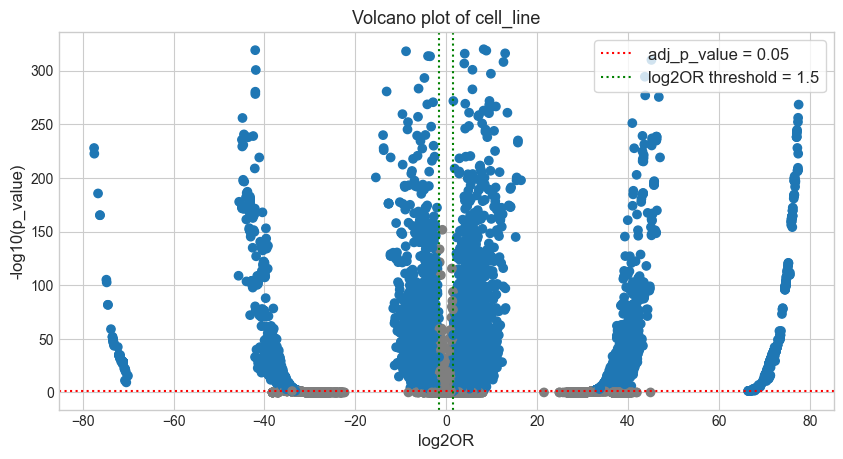

In [17]:
volcano_plot(df,tag="cell_line")

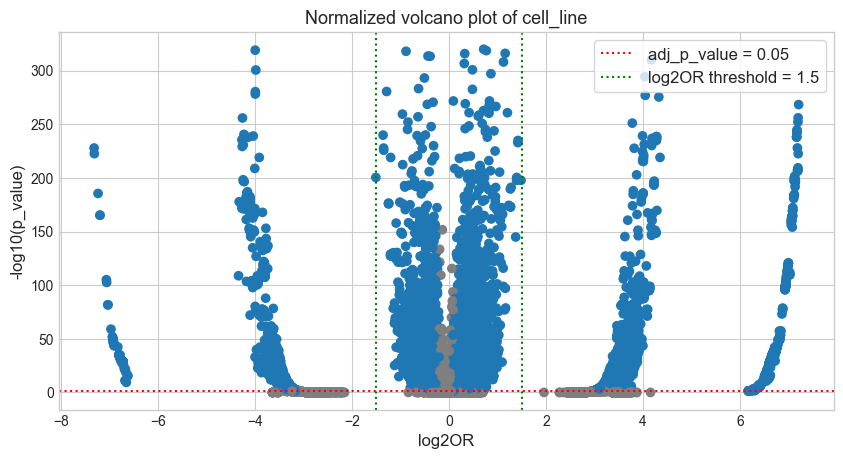

In [23]:
volcano_plot(df,tag="cell_line",normalized=True)

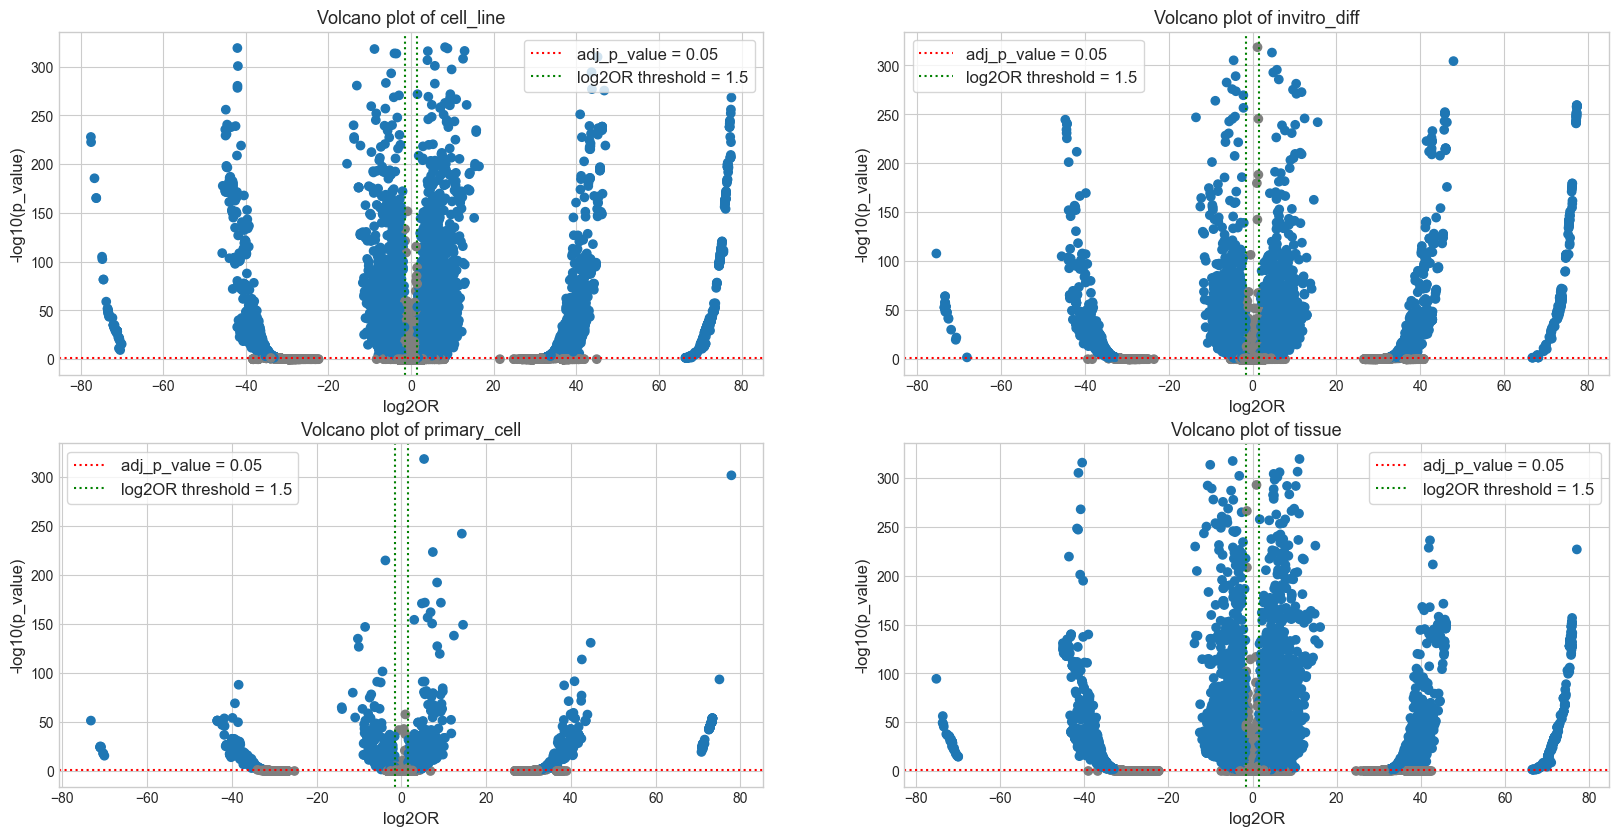

In [39]:
fig,axs=plt.subplots(figsize=(10*2,5*2),ncols=2,nrows=2)
indeces=[(0,0),(0,1),(1,0),(1,1)]
i=0

for k,tab in tabl_dict.items():
    volcano_plot(tab,tag=k,ax=axs[indeces[i]])
    i+=1
    
plt.savefig(figures+"volcano_plot_grid.png")

Make a general dataframe

In [16]:
colnames={e:[] for e in df.keys()}

In [17]:
dfg=pd.DataFrame(colnames)

for t,df in tabl_dict.items():
    df["type"]=t
    dfg=pd.concat([dfg,df])
dfg=dfg.reset_index(drop=True)

/scratch/local/ipykernel_113793/4248749452.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures+"volcano_plot_ensemble.png")
/pkg/python-3.9.12-0/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


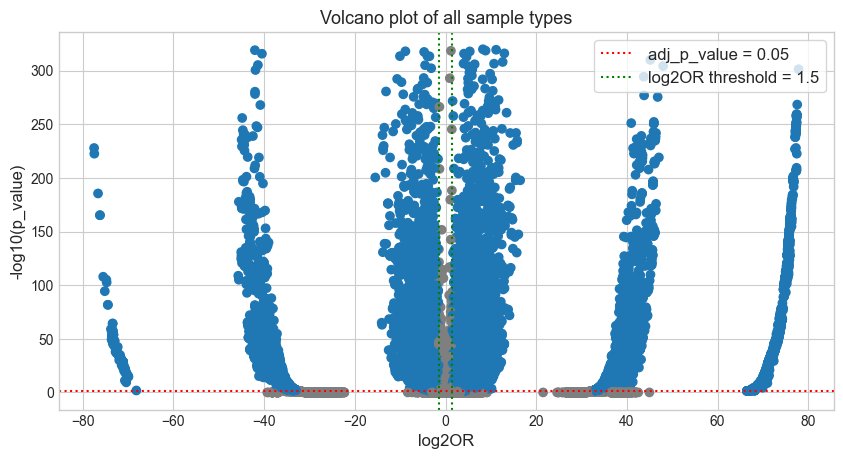

In [40]:
fig,ax=plt.subplots(figsize=(10,5))

volcano_plot(dfg,tag="all sample types",ax=ax)
    
plt.savefig(figures+"volcano_plot_ensemble.png")

In [18]:
g1=dfg[abs(dfg.log2OR)<20]
g2=dfg[(abs(dfg.log2OR)<60) & (abs(dfg.log2OR)>20)]
g3=dfg[abs(dfg.log2OR)>60]

In [19]:
def piechart(df,color_dict=None,ax=None):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(10,5))
        
    dfstats=types_stats(df)
    
    sizes=[e[0] for e in dfstats if e[0]>0.02]
    labels=["-".join(e[2]) for e in dfstats if e[0]>0.02]
    
    sizes.append(1-sum(sizes))
    labels.append("others")
    
    if color_dict is not None:
        colors=[color_dict[l] for l in labels]
    
    ax.pie(sizes,labels=labels,autopct='%1.1f%%',colors=colors)


In [20]:
labels=['IR-IR', 'TSS-PAS', 'IR-TSS', 'IR-PAS', '3AS-IR', '5AS-IR', '3AS-PAS', 'ES-3AS', '5AS-TSS',
        '3AS-5AS', 'TSS-TSS', 'PAS-PAS', 'ME-TSS', 'ME-PAS', 'ME-ME', 'IR-ME','ES-TSS', 'ES-PAS',
        'ES-ME', 'ES-IR', 'ES-ES', 'ES-5AS', '5AS-PAS','5AS-ME', '5AS-5AS','3AS-TSS', '3AS-ME',
        '3AS-3AS',"others"]

palette=sns.color_palette().as_hex()

color_dict={}

for i in range(len(labels)):
    color_dict[labels[i]]=palette[i%10]


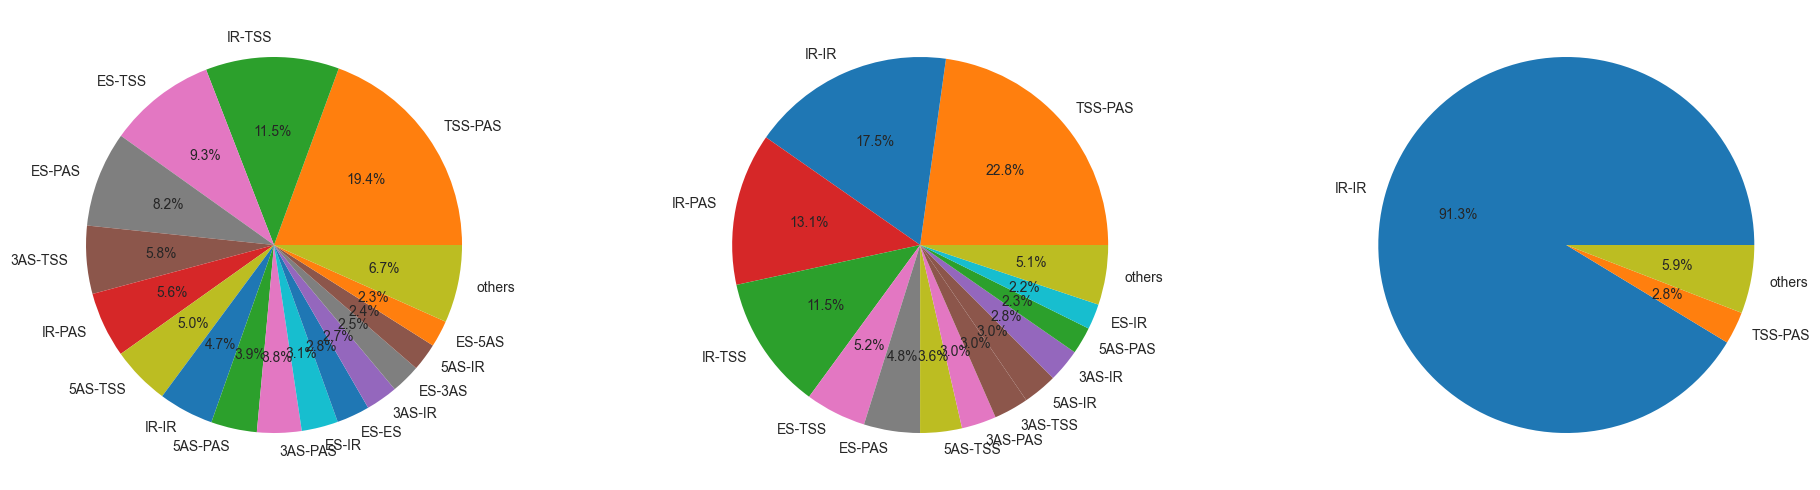

In [90]:
fig,axs=plt.subplots(figsize=(10*2,5),ncols=3)

gs=(g1,g2,g3)

for i in range(3):
    piechart(gs[i],ax=axs[i],color_dict=color_dict)
fig.tight_layout()

In [44]:
def plot_ave_cont(df,ax=None):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(7,6))
        
    all_i=[e for e in range(df.shape[0])]
    i=random.sample(all_i,1000)
    df_s=df.iloc[i,:]
    stats=df_s.mean()
    cont=np.zeros((2,2))
    
    cont[0,0]=stats.priA_priB
    cont[1,0]=stats.priA_altB
    cont[0,1]=stats.altA_priB
    cont[1,1]=stats.altA_altB
    
    cont=pd.DataFrame(cont)
    cont.columns=["priA","altA"]
    cont.index=["priB","altB"]
    
    sns.heatmap(cont,annot=True,ax=ax,center=20,cmap="coolwarm",fmt=".0f")

/scratch/local/ipykernel_67252/649169685.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()
/scratch/local/ipykernel_67252/649169685.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()
/scratch/local/ipykernel_67252/649169685.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()


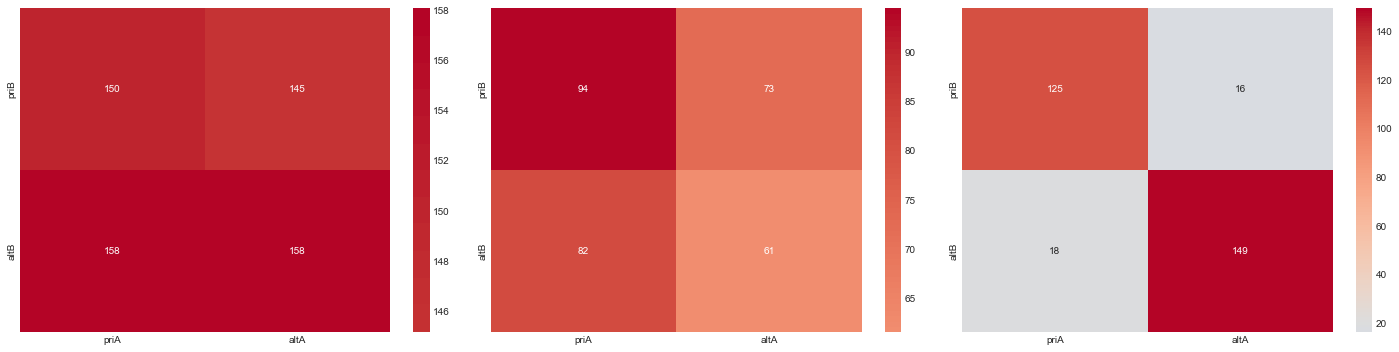

In [45]:
fig,axs=plt.subplots(figsize=(7*3-1,6-1),ncols=3)

gs=(g1,g2,g3)

for i in range(3):
    plot_ave_cont(gs[i],ax=axs[i])

fig.tight_layout()

#plt.savefig(figures+"ave_cont_3.png")

In [112]:
def plor_dist(df,ax=None,tag=""):
    
    if ax is None:
        fig,axs=plt.subplots(figsize=(10*1.5,5),ncols=2)
        
    palette=sns.color_palette().as_hex()
    
    x1=np.array(df.adj_p_value)
    x2=np.array(df.log2OR)

    sns.kdeplot(x1,ax=axs[0],color=palette[0],fill=True)
    axs[0].set_title(f"KDE of the adjusted p-values in {tag}",fontsize=20)

    sns.kdeplot(x2,ax=axs[1],color=palette[1],fill=True)
    axs[1].set_title(f"KDE of the log odds ratio in {tag}",fontsize=20)
    
    if ax is None:
        fig.tight_layout()

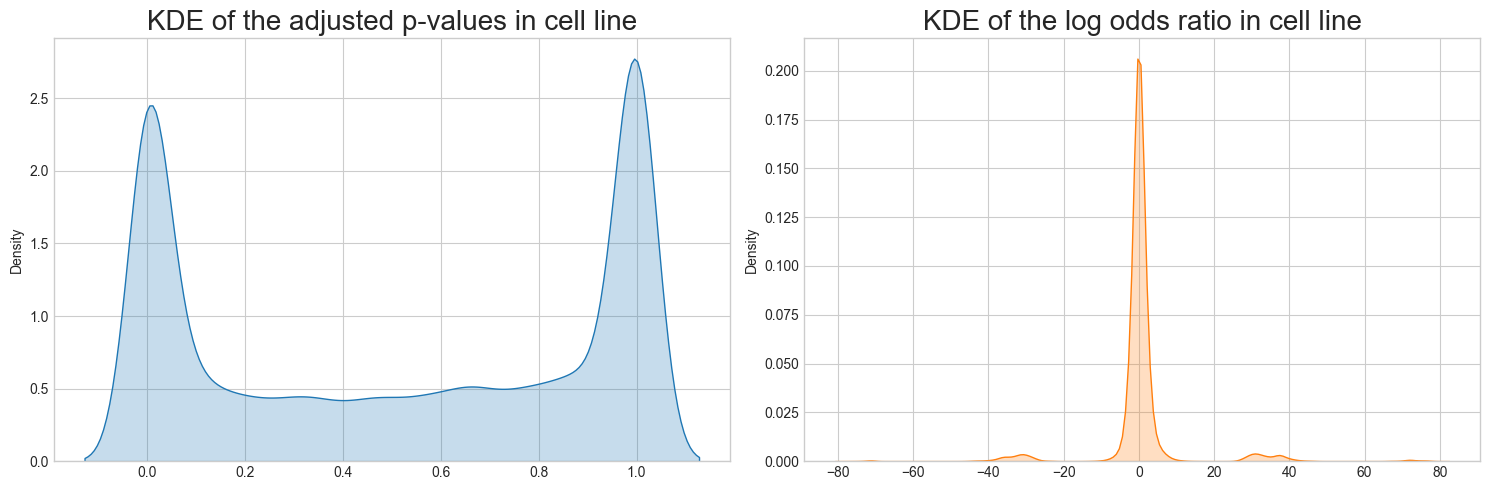

In [113]:
plor_dist(df,tag="cell line")

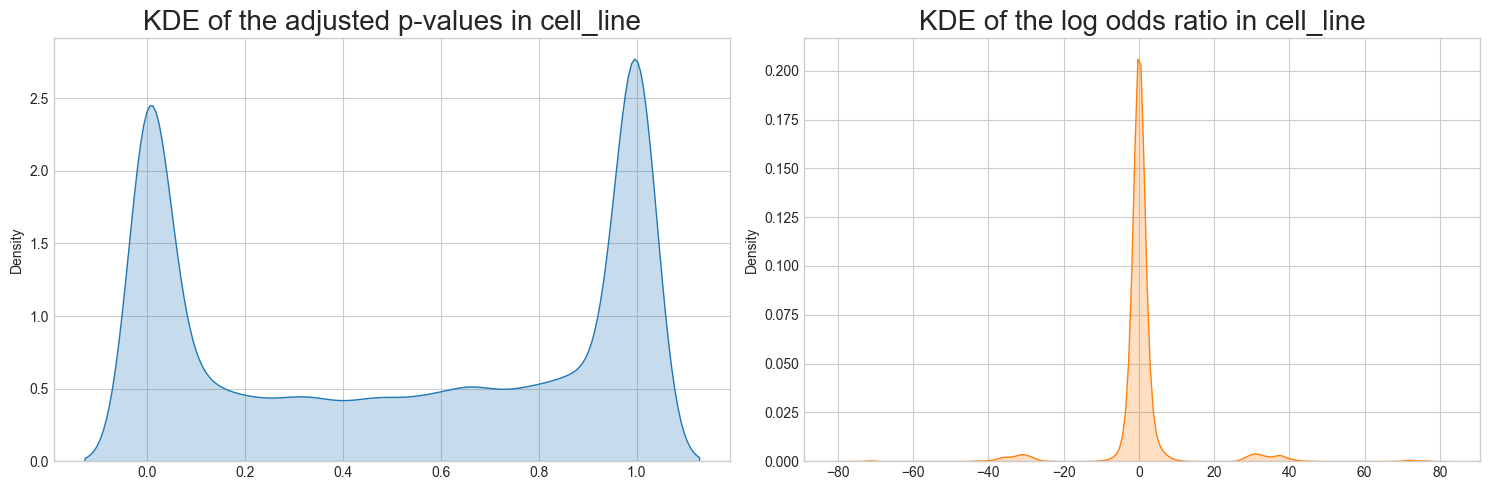

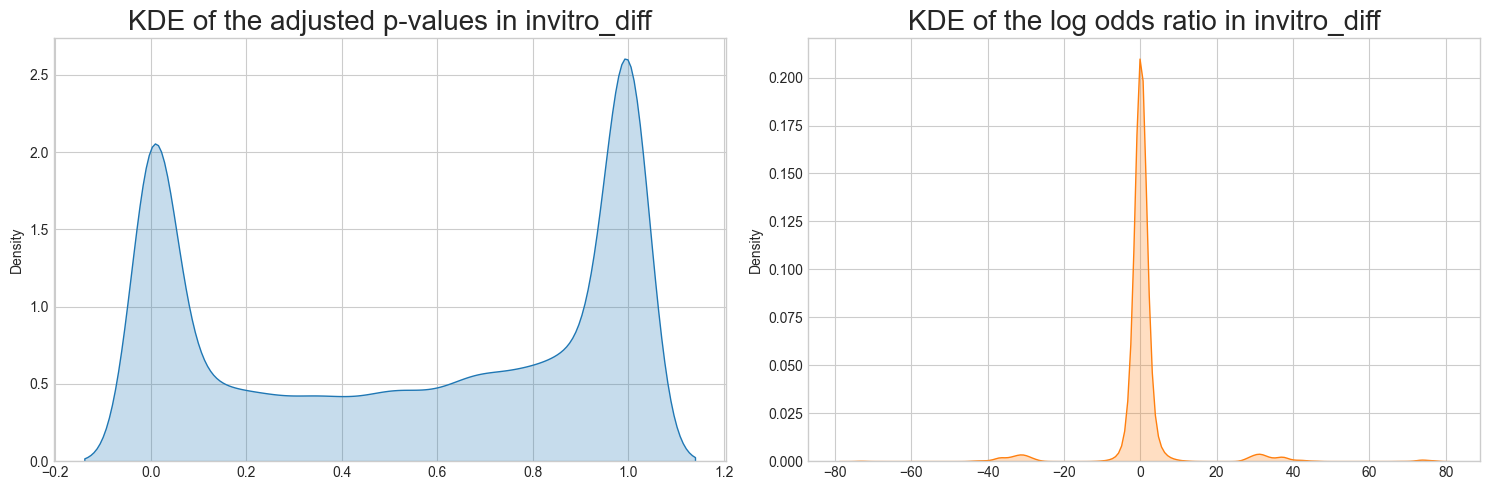

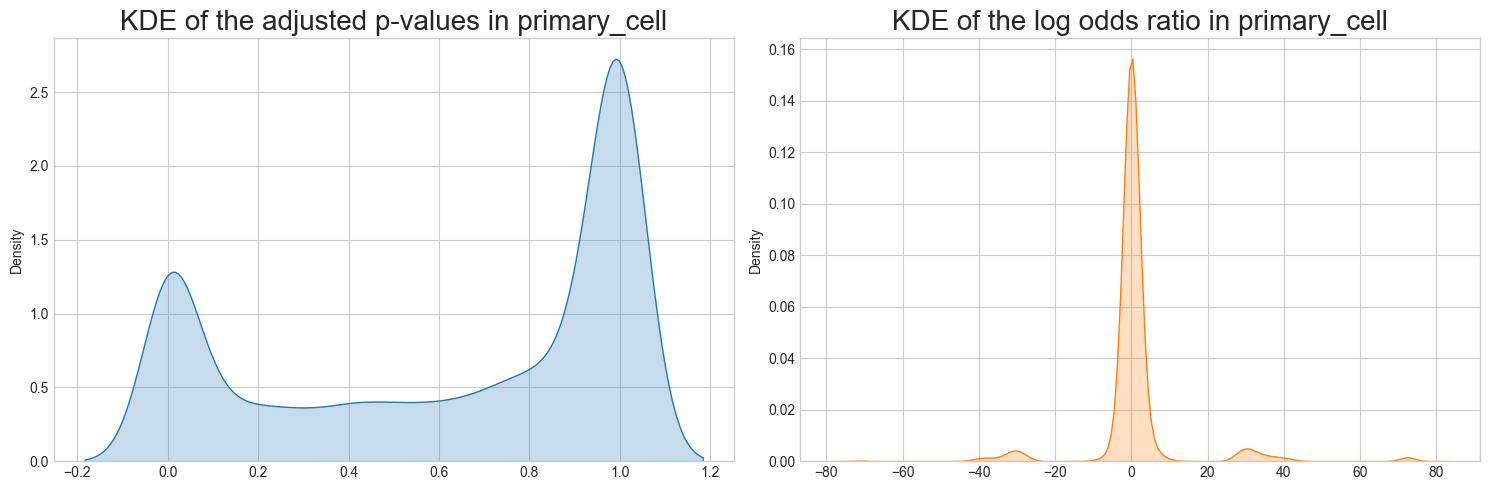

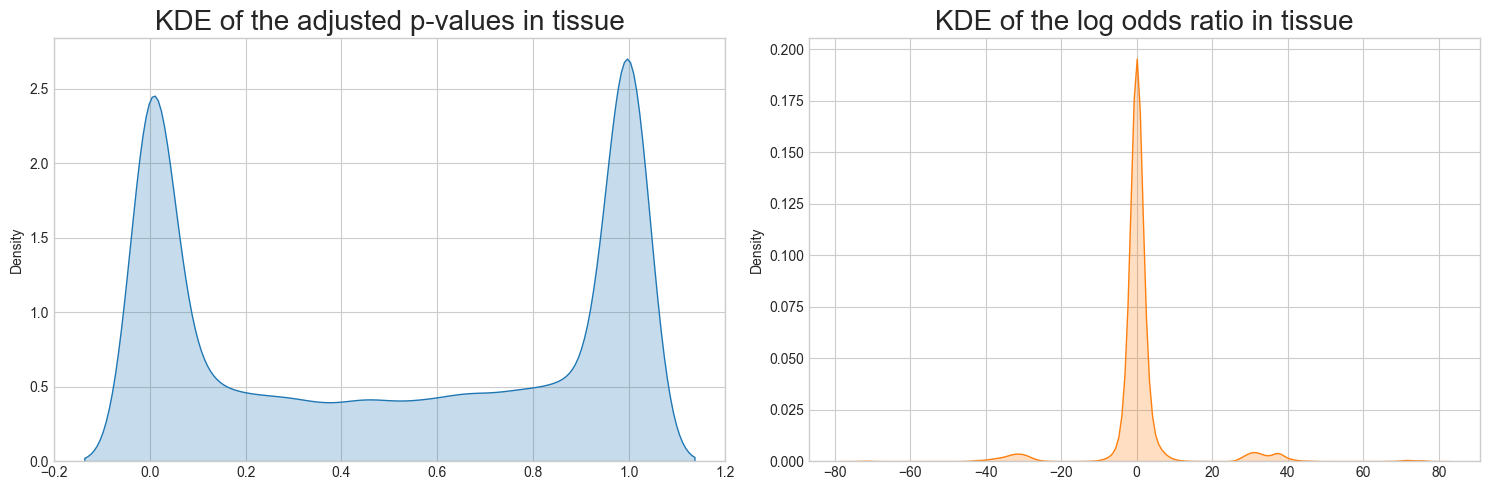

In [114]:
for k,tab in tabl_dict.items():
    plor_dist(tab,tag=k)
    plt.savefig(figures+f"plor_dist_{k}.png")

,gene_id,gene_name,strand,ase1_type,ase2_type,ase1_start,ase1_end,ase2_start,ase2_end,p_value,...,stat,log2OR,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_trID,priA_altB_trID,altA_priB_trID,altA_altB_trID
0,ENSG00000277196.4,AC007325.2,-,ES,ES,148232,150349,151021,161313,9.596263e-183,...,354.653092,0.736271,205,17,39,1147,"[11, 309, 320, 313, 310, 297, 227, 166, 327, 45]","[12, 303, 300, 233, 278, 277, 171, 168, 167, 1...","[14, 217, 299, 270, 266, 263, 187]","[3, 38, 29, 158, 204, 145, 116, 127, 123, 110,..."
1,ENSG00000277196.4,AC007325.2,-,ES,TSS,148232,150349,161313,161624,2.369540e-01,...,0.637066,-0.117802,10,222,84,1188,"[194, 243, 15, 58, 279, 186, 176, 175, 157, 15...","[11, 12, 309, 320, 313, 310, 303, 300, 297, 23...","[18, 1, 33, 62, 221, 220, 199, 195, 32, 256, 2...","[3, 14, 38, 29, 158, 204, 145, 116, 217, 127, ..."
2,ENSG00000182670.13,TTC3,+,5AS,ES,37073364,37087246,37156906,37159698,1.000000e+00,...,0.999554,-0.056951,320,45,249,35,"[17, 4, 473, 42, 31, 198, 234, 126, 122, 284, ...","[41, 771, 706, 1505, 887, 866, 854, 848, 847, ...","[32, 24, 472, 82, 38, 34, 155, 88, 66, 441, 25...","[39, 124, 96, 1525, 892, 889, 853, 846, 812, 8..."
3,ENSG00000182670.13,TTC3,+,5AS,PAS,37073364,37087246,37165549,37166598,5.335174e-02,...,0.791604,-0.088461,744,217,667,154,"[9, 140, 4, 55, 125, 123, 60, 473, 45, 42, 31,...","[17, 41, 126, 706, 1517, 1050, 887, 854, 709, ...","[25, 36, 24, 8, 33, 52, 13, 472, 97, 77, 82, 3...","[32, 39, 155, 441, 257, 96, 742, 380, 371, 370..."
4,ENSG00000182670.13,TTC3,+,5AS,PAS,37073364,37087246,37182773,37182916,4.568130e-01,...,1.164356,-0.036333,898,63,759,62,"[9, 17, 140, 55, 125, 123, 60, 41, 473, 45, 42...","[4, 771, 182, 1505, 844, 807, 698, 439, 297, 2...","[25, 32, 36, 8, 33, 52, 13, 472, 97, 77, 39, 8...","[24, 66, 124, 898, 48, 1525, 892, 857, 853, 84..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84318,ENSG00000186001.13,LRCH3,+,3AS,TSS,197884168,197885513,197791203,197791540,1.000000e+00,...,0.988235,-0.058489,3,30,17,168,"[438, 344, 271, 488, 466, 460, 385]","[77, 69, 145, 564, 417, 263, 121, 402, 390, 313]","[61, 194, 169, 101, 306, 274, 188, 153, 92, 71...","[0, 10, 104, 138, 39, 288, 96, 157, 520, 516, ..."
84319,ENSG00000186001.13,LRCH3,+,3AS,PAS,197884168,197885513,197871324,197874019,1.000000e+00,...,NaN,-0.288305,33,0,183,0,"[77, 69, 145, 564, 438, 417, 344, 271, 263, 12...",[],"[0, 10, 104, 138, 61, 39, 288, 96, 194, 169, 1...",[]
84320,ENSG00000186001.13,LRCH3,+,TSS,PAS,197791203,197791540,197885507,197886804,4.980427e-03,...,2.034600,0.039067,167,18,798,175,"[21, 62, 2, 229, 190, 113, 510, 346, 281, 171,...","[61, 194, 169, 101, 573, 306, 274, 188, 153, 9...","[3, 6, 15, 11, 4, 24, 41, 77, 7, 51, 34, 45, 3...","[0, 10, 104, 138, 39, 96, 399, 157, 93, 570, 5..."
84321,ENSG00000186001.13,LRCH3,+,TSS,PAS,197791203,197791540,197883540,197885831,1.856410e-01,...,1.621277,0.008389,108,10,846,127,"[62, 2, 229, 61, 113, 510, 346, 281, 194, 171,...","[422, 351, 350, 307, 304, 283, 176, 175, 108, ...","[0, 6, 15, 11, 4, 10, 24, 77, 7, 51, 34, 45, 3...","[3, 41, 86, 109, 28, 575, 565, 496, 433, 430, ..."
